# 11.3 Predictive coding (Rao & Ballard, 1999) モデル
Predictive codingの初めの数理的モデルとなる ([Rao & Ballard, *Nat. Neurosci*. 1999](https://www.nature.com/articles/nn0199_79))を実装する。

## 11.3.1 観測世界の階層的予測
構築するネットワークは入力層を含め、3層のネットワークとする。網膜への入力として画像 $\mathbf{x} \in \mathbb{R}^{n_0}$を考える。画像 $\mathbf{x}$ の観測世界における隠れ変数、すなわち**潜在変数** (latent variable)を$\mathbf{r} \in \mathbb{R}^{n_1}$とし、ニューロン群によって発火率で表現されているとする (真の変数と $\mathbf{r}$は異なるので文字を分けるべきだが簡単のためにこう表す)。このとき、

$$
\mathbf{x} = f(\mathbf{U}\mathbf{r}) + \boldsymbol{\epsilon} \tag{1}
$$

が成立しているとする。ただし、$f(\cdot)$は活性化関数 (activation function)、$\mathbf{U} \in \mathbb{R}^{n_0 \times n_1}$は重み行列である。
$\boldsymbol{\epsilon} \in \mathbb{R}^{n_0}$ は $\mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$ からサンプリングされるとする。

潜在変数 $\mathbf{r}$はさらに高次 (higher-level)の潜在変数 $\mathbf{r}^h$により、次式で表現される。

$$
\mathbf{r} = \mathbf{r}^{td}+\boldsymbol{\epsilon}^{td}=f(\mathbf{U}^h \mathbf{r}^h)+\boldsymbol{\epsilon}^{td} \tag{2}
$$

ただし、Top-downの予測信号を $\mathbf{r}^{td}:=f(\mathbf{U}^h \mathbf{r}^h)$とした。また、$\mathbf{r}^{td} \in \mathbb{R}^{n_1}$, $\mathbf{r}^{h} \in \mathbb{R}^{n_2}$, $\mathbf{U}^h \in \mathbb{R}^{n_1 \times n_2}$ である。
$\boldsymbol{\epsilon}^{td} \in \mathbb{R}^{n_1}$は$\mathcal{N}(\mathbf{0}$, $\sigma_{td}^2 \mathbf{I}$) からサンプリングされるとする。

話は飛ぶが、Predictive codingのネットワークの特徴は
- 階層的な構造
- 高次による低次の予測 (Feedback or Top-down信号)
- 低次から高次への誤差信号の伝搬 (Feedforward or Bottom-up 信号)

である。ここまでは高次表現による低次表現の予測、というFeedback信号について説明してきたが、この部分はSparse codingでも同じである。それではPredictive codingのもう一つの要となる、低次から高次への予測誤差の伝搬というFeedforward信号はどのように導かれるのだろうか。結論から言えば、これは**復元誤差 (reconstruction error)の最小化を行う再帰的ネットワーク (recurrent network)を考慮することで自然に導かれる**。

## 11.3.2 損失関数と学習則
### 事前分布の設定
$\mathbf{r}$の事前分布$p(\mathbf{r})$はCauchy分布を用いる。$p(\mathbf{r})$の負の対数事前分布を$g(\mathbf{r}):=-\log p(\mathbf{r})$としておく。

$$
\begin{align}
p(\mathbf{r})&=\prod_i p(r_i)=\prod_i \exp\left[-\alpha \ln(1+r_i^2)\right]\\
g(\mathbf{r})&=-\ln p(\mathbf{r})=\alpha \sum_i \ln(1+r_i^2)\\
g'(\mathbf{r})&=\frac{\partial g(\mathbf{r})}{\partial \mathbf{r}}=\left[\frac{2\alpha r_i}{1+r_i^2}\right]_i
\end{align}
$$

次に重み行列$\mathbf{U}$の事前分布 $p(\mathbf{U})$はGaussian分布とする。$p(\mathbf{U})$の負の対数事前分布を$h(\mathbf{U}):=-\ln p(\mathbf{U})$とすると、次のように表される。

$$
\begin{align}
p(\mathbf{U})&=\exp(-\lambda\|\mathbf{U}\|^2_F)\\
h(\mathbf{U})&=-\ln p(\mathbf{U})=\lambda\|\mathbf{U}\|^2_F\\
h'(\mathbf{U})&=\frac{\partial h(\mathbf{U})}{\partial \mathbf{U}}=2\lambda \mathbf{U}
\end{align}
$$

ただし、$\|\cdot \| _ F^2$はフロベニウスノルムを意味する。

### 損失関数の設定
[11-2](https://compneuro-julia.github.io/11-2_sparse-coding.html)と同様に考えることにより、損失関数 $E$を次のように定義する。

$$
\begin{align}
E=\underbrace{\frac{1}{\sigma^{2}}\|\mathbf{x}-f(\mathbf{U} \mathbf{r})\|^2+\frac{1}{\sigma_{t d}^{2}}\left\|\mathbf{r}-f(\mathbf{U}^h \mathbf{r}^h)\right\|^2}_{\text{reconstruction error}}+\underbrace{g(\mathbf{r})+g(\mathbf{r}^{h})+h(\mathbf{U})+h(\mathbf{U}^h)}_{\text{sparsity penalty}}\tag{4}
\end{align}
$$

潜在変数 $\mathbf{r}, \mathbf{r}^h$ と 重み行列 $\mathbf{U}, \mathbf{U}^h$ のそれぞれに事前分布を仮定しているため、これらについてのMAP推定を行うことに相当する。

### 再帰ネットワークの更新則
簡単のために$\mathbf{z}:=\mathbf{U}\mathbf{r}, \mathbf{z}^h:=\mathbf{U}^h\mathbf{r}^h$とする。

$$
\begin{align}
\frac{d \mathbf{r}}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \mathbf{r}}=k_{1}\cdot\Bigg(\frac{1}{\sigma^{2}} \mathbf{U}^{T}\bigg[\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}\odot\underbrace{(\mathbf{x}-f(\mathbf{z}))}_{\text{bottom-up error}}\bigg]-\frac{1}{\sigma_{t d}^{2}}\underbrace{\left(\mathbf{r}-f(\mathbf{z}^h)\right)}_{\text{top-down error}}-\frac{1}{2}g'(\mathbf{r})\Bigg)\tag{5}\\
\frac{d \mathbf{r}^h}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \mathbf{r}^h}=k_{1}\cdot\Bigg(\frac{1}{\sigma_{t d}^{2}}(\mathbf{U}^h)^T\bigg[\frac{\partial f(\mathbf{z}^h)}{\partial \mathbf{z}^h}\odot\underbrace{\left(\mathbf{r}-f(\mathbf{z}^h)\right)}_{\text{bottom-up error}}\bigg]-\frac{1}{2}g'(\mathbf{r}^h)\Bigg)\tag{6}
\end{align}
$$

ただし、$k_1$は更新率 (updating rate)である。または、発火率の時定数を$\tau:=1/k_1$として、$k_1$は発火率の時定数$\tau$の逆数であると捉えることもできる。ここで(5)式において、中間表現 $\mathbf{r}$ のダイナミクスはbottom-up errorとtop-down errorで記述されている。このようにbottom-up errorが $\mathbf{r}$ への入力となることは自然に導出される。なお、top-down errorに関しては高次からの予測 (prediction)の項 $f(\mathbf{x}^h)$とleaky-integratorとしての項 $-\mathbf{r}$に分割することができる。また$\mathbf{U}^T, (\mathbf{U}^h)^T$は重み行列の転置となっており、bottom-upとtop-downの投射において対称な重み行列を用いることを意味している。$-g'(\mathbf{r})$は発火率を抑制してスパースにすることを目的とする項だが、無理やり解釈をすると自己再帰的な抑制と言える。

### 画像データの読み込み
11-2と同様にデータは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできるファイルを用いる。

In [1]:
using MAT

# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = matopen("../_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images)

### モデルの定義
必要なパッケージを読み込む。

In [2]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter
using PyPlot

モデルを定義する。

In [3]:
@kwdef struct RBParameter{FT}
    α::FT = 1.0
    αh::FT = 0.05
    var::FT = 1.0
    vartd::FT = 10
    inv_var::FT = 1/var       
    inv_vartd::FT = 1/vartd
    k1::FT = 0.3 # k_1: update rate
    λ::FT = 0.02 # regularization parameter
end

@kwdef mutable struct RaoBallard1999Model{FT}
    param::RBParameter = RBParameter{FT}()
    num_units_lv0::UInt16 = 256 # number of units of level0
    num_units_lv1::UInt16 = 32
    num_units_lv2::UInt16 = 128
    num_lv1::UInt16 = 3
    k2::FT = 0.2 # k_2: learning rate
    r::Array{FT} = zeros(num_lv1, num_units_lv1) # activity of neurons
    rh::Array{FT} = zeros(num_units_lv2) # activity of neurons
    U::Array{FT} = randn(num_units_lv0, num_units_lv1) .* sqrt(2.0 / (num_units_lv0+num_units_lv1))
    Uh::Array{FT} = randn(num_lv1*num_units_lv1, num_units_lv2) .* sqrt(2.0 / (num_lv1*num_units_lv1+num_units_lv2))
end

パラメータを更新する関数を定義する。

In [4]:
function update!(variable::RaoBallard1999Model, param::RBParameter, inputs::Array, training::Bool)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param

    r_reshaped = r[:] # (96)

    fx = r * U' # (3, 256)
    fxh = Uh * rh # (96, )

    # Calculate errors
    error = inputs - fx # (3, 256)
    errorh = r_reshaped - fxh # (96, ) 
    errorh_reshaped = reshape(errorh, (num_lv1, num_units_lv1)) # (3, 32)

    g_r = α * r ./ (1.0 .+ r .^ 2) # (3, 32)
    g_rh = αh * rh ./ (1.0 .+ rh .^ 2) # (64, )

    # Update r and rh
    dr = k1 * (inv_var * error * U - inv_vartd * errorh_reshaped - g_r)
    drh = k1 * (inv_vartd * Uh' * errorh - g_rh)
    
    r[:, :] += dr
    rh[:] += drh
    
    if training 
        U[:, :] += k2 * (inv_var * error' * r - num_lv1 * λ * U)
        Uh[:, :] += k2 * (inv_vartd * errorh * rh' - λ * Uh)
    end

    return error, errorh, dr, drh
end

update! (generic function with 1 method)

入力に乗じるGaussianフィルタを定義する。

In [5]:
# Gaussian mask for inputs
function GaussianMask(sizex=16, sizey=16, sigma=5)
    x = 0:sizex-1
    y = 0:sizey-1
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    
    x0 = (sizex-1) / 2
    y0 = (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(sigma^2)))
    return mask ./ sum(mask)
end

GaussianMask (generic function with 4 methods)

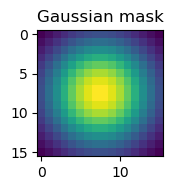

In [6]:
gau = GaussianMask()
figure(figsize=(2,2))
title("Gaussian mask")
imshow(gau)
tight_layout()

損失関数を定義する。

In [7]:
function calculate_total_error(error, errorh, variable::RaoBallard1999Model, param::RBParameter)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param
    recon_error = inv_var * sum(error.^2) + inv_vartd * sum(errorh.^2)
    sparsity_r = α * sum(r.^2) + αh * sum(rh.^2)
    sparsity_U = λ * (sum(U.^2) + sum(Uh.^2))
    return recon_error + sparsity_r + sparsity_U
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する。外側の`for loop`では画像パッチの作成と`r`の初期化を行う。内側の`for loop`では`r`が収束するまで更新を行い、収束したときに重み行列`Phi`を更新する。

In [8]:
function run_simulation(imgs, num_iter, nt_max, eps)
    # Define model
    model = RaoBallard1999Model{Float32}()
    
    # Simulation constants
    H, W, num_images = size(imgs)
    input_scale = 40 # scale factor of inputs
    gmask = GaussianMask() # Gaussian mask
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get images randomly
        idx = rand(1:num_images)
        img = imgs[:, :, idx]

        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-27)
        beginy = rand(1:H-17)
        img_clopped = img[beginy:beginy+15, beginx:beginx+25]

        # Clop three patches
        inputs = hcat([(gmask .* img_clopped[:, 1+i*5:i*5+16])[:] for i = 0:2]...)'
        inputs = (inputs .- mean(inputs)) .* input_scale

        # Reset states
        model.r = inputs * model.U 
        model.rh = model.Uh' * model.r[:]

        # Input an image patch until latent variables are converged 
        for i in 1:nt_max
            # Update r and rh without update weights 
            error, errorh, dr, drh = update!(model, model.param, inputs, false)

            # Compute norm of r and rh
            dr_norm = sqrt(sum(dr.^2))
            drh_norm = sqrt(sum(drh.^2))

            # Check convergence of r and rh, then update weights
            if dr_norm < eps && drh_norm < eps
                error, errorh, dr, drh = update!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, errorh, model, model.param) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if i >= nt_max-2
                println("Error at patch:", iter)
                println(dr_norm, drh_norm)
                break
            end
        end


        # Decay learning rate         
        if iter % 40 == 39
            model.k2 /= 1.015
        end

        # Print moving average error
        if iter % 1000 == 0
            moving_average_error = mean(errorarr[iter-999:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

### シミュレーションの実行

In [9]:
# Simulation constants
num_iter = 5000 # number of iterations
nt_max = 1000 # Maximum number of simulation time
eps = 1e-3 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, eps)

Computing...  0%|█                                      |  ETA: 4:16:37

Computing...  0%|█                                      |  ETA: 0:12:18

Computing...  1%|█                                      |  ETA: 0:08:21

Computing...  1%|█                                      |  ETA: 0:06:10

Computing...  1%|█                                      |  ETA: 0:04:52

Computing...  2%|█                                      |  ETA: 0:03:55

Computing...  2%|█                                      |  ETA: 0:03:18

Computing...  2%|█                                      |  ETA: 0:02:44

Computing...  3%|██                                     |  ETA: 0:02:16

Computing...  4%|██                                     |  ETA: 0:01:51

Computing...  5%|██                                     |  ETA: 0:01:33

Computing...  5%|███                                    |  ETA: 0:01:20

Computing...  6%|███                                    |  ETA: 0:01:11

Computing...  7%|███                                    |  ETA: 0:01:04

Computing...  8%|████                                   |  ETA: 0:00:57

Computing...  9%|████                                   |  ETA: 0:00:52

Computing... 10%|████                                   |  ETA: 0:00:47

Computing... 11%|█████                                  |  ETA: 0:00:44

Computing... 12%|█████                                  |  ETA: 0:00:41

Computing... 12%|█████                                  |  ETA: 0:00:39

Computing... 13%|██████                                 |  ETA: 0:00:36

Computing... 14%|██████                                 |  ETA: 0:00:35

Computing... 15%|██████                                 |  ETA: 0:00:33

Computing... 16%|███████                                |  ETA: 0:00:31

Computing... 17%|███████                                |  ETA: 0:00:30

Computing... 18%|████████                               |  ETA: 0:00:28

Computing... 19%|████████                               |  ETA: 0:00:27

Computing... 20%|████████                               |  ETA: 0:00:26

iter: 1000/5000, Moving average error:

Computing... 20%|████████                               |  ETA: 0:00:26

1.9877597601300012


Computing... 21%|█████████                              |  ETA: 0:00:25

Computing... 22%|█████████                              |  ETA: 0:00:24

Computing... 23%|█████████                              |  ETA: 0:00:23

Computing... 24%|██████████                             |  ETA: 0:00:22

Computing... 25%|██████████                             |  ETA: 0:00:22

Computing... 26%|███████████                            |  ETA: 0:00:21

Computing... 27%|███████████                            |  ETA: 0:00:20

Computing... 28%|███████████                            |  ETA: 0:00:20

Computing... 29%|████████████                           |  ETA: 0:00:19

Computing... 30%|████████████                           |  ETA: 0:00:18[39

m

Computing... 31%|████████████                           |  ETA: 0:00:18

Computing... 31%|█████████████                          |  ETA: 0:00:17

Computing... 32%|█████████████                          |  ETA: 0:00:17

Computing... 33%|██████████████                         |  ETA: 0:00:16

Computing... 34%|██████████████                         |  ETA: 0:00:16

Computing... 35%|██████████████                         |  ETA: 0:00:15

Computing... 36%|███████████████                        |  ETA: 0:00:15

Computing... 37%|███████████████                        |  ETA: 0:00:15

Computing... 38%|███████████████                        |  ETA: 0:00:14

Computing... 39%|████████████████                       |  ETA: 0:00:14

Computing... 40%|████████████████                       |  ETA: 0:00:13

iter: 2000/5000, Moving average error:1.6849709888898579

Computing... 41%|████████████████                       |  ETA: 0:00:13

Computing... 42%|█████████████████                      |  ETA: 0:00:13

Computing... 43%|█████████████████                      |  ETA: 0:00:12

Computing... 44%|██████████████████                     |  ETA: 0:00:12

Computing... 45%|██████████████████                     |  ETA: 0:00:12

Computing... 46%|██████████████████                     |  ETA: 0:00:11

Computing... 47%|███████████████████                    |  ETA: 0:00:11

Computing... 48%|███████████████████                    |  ETA: 0:00:11

Computing... 49%|████████████████████                   |  ETA: 0:00:10

Computing... 50%|████████████████████                   |  ETA: 0:00:10

Computing... 51%|████████████████████                   |  ETA: 0:00:10

Computing... 52%|█████████████████████                  |  ETA: 0:00:10

Computing... 53%|█████████████████████                  |  ETA: 0:00:09

Computing... 54%|█████████████████████                  |  ETA: 0:00:09

Computing... 55%|██████████████████████                 |  ETA: 0:00:09

Computing... 56%|██████████████████████                 |  ETA: 0:00:09

Computing... 57%|███████████████████████                |  ETA: 0:00:08

Computing... 58%|███████████████████████                |  ETA: 0:00:08[39

m

Computing... 59%|███████████████████████                |  ETA: 0:00:08

Computing... 60%|████████████████████████               |  ETA: 0:00:08

iter: 3000/5000, Moving average error:1.5846195254859687


Computing... 61%|████████████████████████               |  ETA: 0:00:07

Computing... 62%|█████████████████████████              |  ETA: 0:00:07

Computing... 63%|█████████████████████████              |  ETA: 0:00:07

Computing... 64%|█████████████████████████              |  ETA: 0:00:07

Computing... 65%|██████████████████████████             |  ETA: 0:00:06

Computing... 65%|██████████████████████████             |  ETA: 0:00:06

Computing... 66%|██████████████████████████             |  ETA: 0:00:06

Computing... 67%|███████████████████████████            |  ETA: 0:00:06

Computing... 68%|███████████████████████████            |  ETA: 0:00:06

Computing... 69%|████████████████████████████           |  ETA: 0:00:05

Computing... 70%|████████████████████████████           |  ETA: 0:00:05

Computing... 71%|████████████████████████████           |  ETA: 0:00:05

Computing... 72%|█████████████████████████████          |  ETA: 0:00:05

Computing... 73%|█████████████████████████████          |  ETA: 0:00:05

Computing... 74%|█████████████████████████████          |  ETA: 0:00:05

Computing... 75%|██████████████████████████████         |  ETA: 0:00:04

Computing... 76%|██████████████████████████████         |  ETA: 0:00:04

Computing... 77%|██████████████████████████████         |  ETA: 0:00:04

Computing... 78%|███████████████████████████████        |  ETA: 0:00:04

Computing... 79%|███████████████████████████████        |  ETA: 0:00:04

Computing... 80%|████████████████████████████████       |  ETA: 0:00:03

iter: 4000/5000, Moving average error:1.7399943715411437


Computing... 81%|████████████████████████████████       |  ETA: 0:00:03

Computing... 82%|████████████████████████████████       |  ETA: 0:00:03

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 85%|█████████████████████████████████      |  ETA: 0:00:03[39

m

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:02

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:01

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:01

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:01[39

m

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:00

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:00

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:00:16


iter: 5000/5000, Moving average error:1.7053817479194067


(RaoBallard1999Model{Float32}(RBParameter{Float32}(1.0f0, 0.05f0, 1.0f0, 10.0f0, 1.0f0, 0.1f0, 0.3f0, 0.02f0), 0x0100, 0x0020, 0x0080, 0x0003, 0.03110101f0, Float32[-0.00824186 0.00076267065 … -0.0017981651 0.006455577; -0.01924497 0.017583279 … 0.018657077 -0.030733058; -0.010899528 0.013336649 … 0.021548357 -0.01537862], Float32[1.2467227f-6, 6.188424f-9, -1.7603699f-6, -1.5800551f-6, -1.8311783f-6, 2.5246848f-6, 1.4961093f-6, -3.1347676f-7, -3.3276142f-6, 2.1325047f-7  …  -4.7322985f-7, 8.707846f-7, 4.2245483f-6, -5.2649136f-7, 3.9593774f-6, -2.9620421f-6, -3.421867f-6, -4.219836f-7, 1.5093103f-6, -2.227827f-6], Float32[7.678136f-5 0.0003212644 … 0.00043011174 -0.001176153; -7.9100086f-5 0.00021398369 … 0.0002151959 -0.0007064115; … ; 2.9399911f-5 0.00032745875 … 0.000507407 -0.00092851394; 0.00015508196 0.00039373167 … 0.00060541567 -0.0013524585], Float32[-8.505269f-6 -1.0258409f-5 … -1.3046307f-5 4.6789132f-6; -5.5643636f-6 1.3658173f-5 … -7.083875f-6 1.0122233f-5; … ; -8.080292f

### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう。損失が低下し、学習が進行したことが分かる。

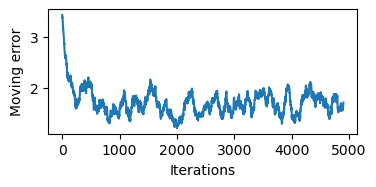

In [10]:
function moving_average(x, n=100)
    ret = cumsum(x)
    ret[n:end] = ret[n:end] - ret[1:end-n+1]
    return ret[n - 1:end] / n
end

# Plot error
moving_average_error = moving_average(errorarr)
figure(figsize=(4, 2))
ylabel("Moving error")
xlabel("Iterations")
plot(1:size(moving_average_error)[1], moving_average_error)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 ($\mathbf{U}$)を可視化してみよう。

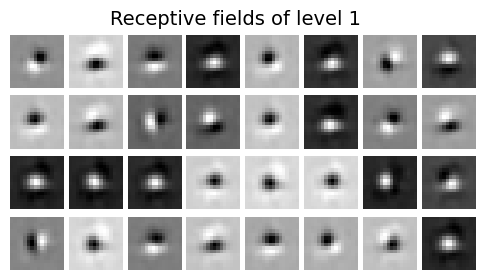

In [11]:
# Plot Receptive fields
figure(figsize=(6, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:32
    subplot(4, 8, i)
    imshow(reshape(model.U[:, i], (16, 16)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields of level 1", fontsize=14)
subplots_adjust(top=0.9)

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表す。Gaborフィルタ様の局所受容野が得られている。次に、Level2のニューロンの受容野は$\mathbf{U}$と$\mathbf{U}^h$の積を計算することで描画できる。

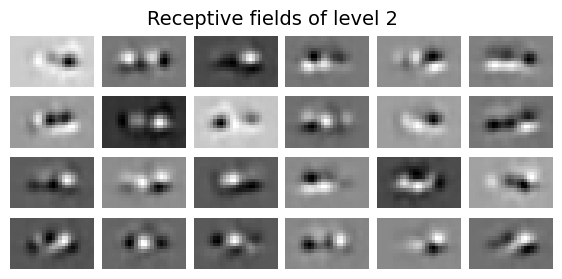

In [12]:
# Plot Receptive fields of level 2
zero_padding = zeros(80, 32)
U0 = [model.U; zero_padding; zero_padding]
U1 = [zero_padding; model.U; zero_padding]
U2 = [zero_padding; zero_padding; model.U]
U_ = [U0 U1 U2]
Uh_ = U_ * model.Uh 

figure(figsize=(7, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:24
    subplot(4, 6, i)
    imshow(reshape(Uh_[:, i], (16, 26)), cmap="gray")
    axis("off")
end

suptitle("Receptive fields of level 2", fontsize=14)
subplots_adjust(top=0.9)